In [10]:
import pandas as pd
import numpy as np
import optuna
import pickle
import sys
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Optuna Logging
optuna.logging.set_verbosity(optuna.logging.INFO)

In [11]:
df = pd.read_csv('innings_1.csv')
print(f"Original Rows: {len(df)}")

# 🚨 CRITICAL FIX: Remove Hidden Chase Matches
if 'runs_target' in df.columns:
    df = df[df['runs_target'].isna()]  # Keep only true 1st innings (no target)

# Also filter for innings == 1 as backup
df = df[df['innings'] == 1]
print(f"Cleaned 1st Innings Rows (Removed Chase Matches): {len(df)}")

Original Rows: 143359
Cleaned 1st Innings Rows (Removed Chase Matches): 143359


C:\Users\lenovo\AppData\Local\Temp\ipykernel_3484\2623691790.py:1: DtypeWarning: Columns (28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('innings_1.csv')


In [12]:
matches = pd.read_csv("matches.csv")
right_col = 'id' if 'id' in matches.columns else 'match_id'
df = df.merge(matches[[right_col, 'venue']], left_on='match_id', right_on=right_col)

# Rename venue to city for consistency
df.rename(columns={'venue': 'city'}, inplace=True)
df['city'] = df['city'].fillna('Unknown')

# Fix team name inconsistencies
df['batting_team'] = df['batting_team'].str.replace('Rising Pune Supergiants', 'Rising Pune Supergiant')
df['bowling_team'] = df['bowling_team'].str.replace('Rising Pune Supergiants', 'Rising Pune Supergiant')

print("✅ Data Loaded.")
print("Engineering Features...")

✅ Data Loaded.
Engineering Features...


In [13]:
df = df[df['innings'] == 1]

# 1. Calculate TOTAL SCORE for each match
total_scores = df.groupby('match_id')['runs_total'].sum().reset_index()
total_scores.rename(columns={'runs_total': 'final_total_runs'}, inplace=True)
df = df.merge(total_scores, on='match_id')

# 2. Current Situation - CUMSUM to get running totals
df['current_score'] = df.groupby('match_id')['runs_total'].cumsum()
df['wickets_fallen'] = df.groupby('match_id')['is_wicket'].cumsum()

# 🔴 FIX: wickets_left should DECREASE when more wickets fall (inverted logic)
df['wickets_left'] = 10 - df['wickets_fallen']

# Verify the logic: wickets_left should be lower when wickets_fallen is higher
print("\n--- Wickets Logic Check ---")
print(df[['match_id', 'wickets_fallen', 'wickets_left']].head(20))

# 3. Balls & Overs
df['balls_bowled'] = (df['over'] * 6) + df['ball']
df['balls_left'] = 120 - df['balls_bowled']

# 4. Current Run Rate (CRR)
df['crr'] = (df['current_score'] * 6) / df['balls_bowled']
df['crr'] = df['crr'].fillna(0).replace([np.inf, -np.inf], 0)

# 5. Runs in Last 5 Overs (rolling sum over 30 balls = 5 overs)
# 🔴 FIX: Corrected rolling window calculation
groups = df.groupby('match_id')
match_ids = df['match_id'].unique()
runs_last_5 = []

for match_id in match_ids:
    group = groups.get_group(match_id)
    # Rolling window of 30 balls (5 overs)
    rolling_sum = group['runs_total'].rolling(window=30, min_periods=1).sum().values.tolist()
    runs_last_5.extend(rolling_sum)

df['runs_last_5'] = runs_last_5
df['runs_last_5'] = df['runs_last_5'].fillna(0)

# Extract year from date
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y', errors='coerce')
df['year'] = df['date'].dt.year

print("✅ Features Created (Target: 'final_total_runs').")
print(f"Dataframe Shape after cleaning: {df.shape}")


--- Wickets Logic Check ---
    match_id  wickets_fallen  wickets_left
0     335982               0            10
1     335982               0            10
2     335982               0            10
3     335982               0            10
4     335982               0            10
5     335982               0            10
6     335982               0            10
7     335982               0            10
8     335982               0            10
9     335982               0            10
10    335982               0            10
11    335982               0            10
12    335982               0            10
13    335982               0            10
14    335982               0            10
15    335982               0            10
16    335982               0            10
17    335982               0            10
18    335982               0            10
19    335982               0            10
✅ Features Created (Target: 'final_total_runs').
Dataframe Shape aft

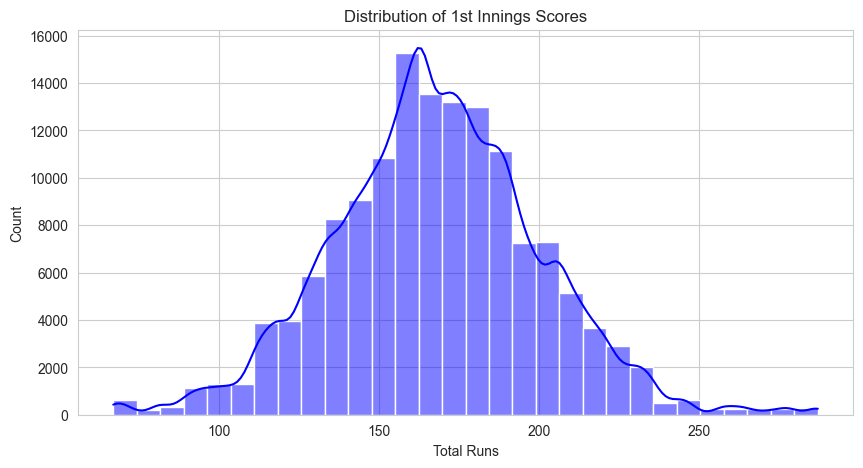

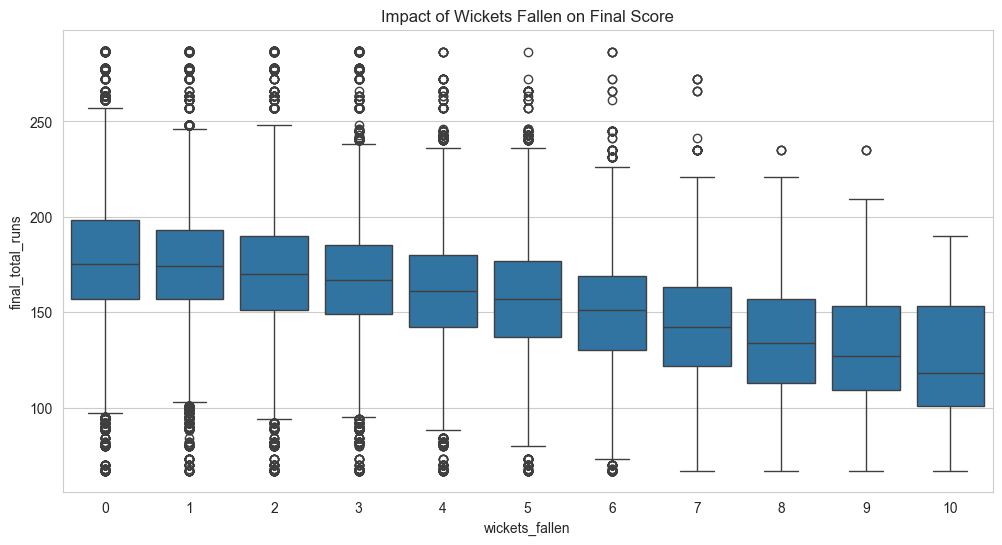

C:\Users\lenovo\AppData\Local\Temp\ipykernel_3484\840132568.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.index, y=top_cities.values, palette='coolwarm')


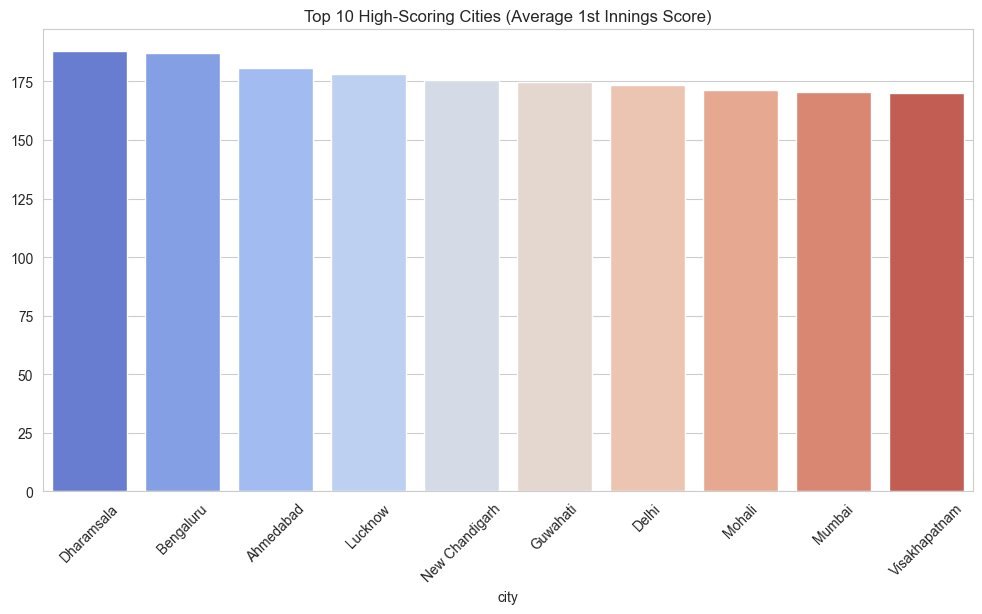

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visuals style
sns.set_style('whitegrid')

# 1. Distribution of Final Scores
plt.figure(figsize=(10, 5))
sns.histplot(df['final_total_runs'], kde=True, bins=30, color='blue')
plt.title('Distribution of 1st Innings Scores')
plt.xlabel('Total Runs')
plt.show()

# 2. Wickets vs Final Score (Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='wickets_fallen', y='final_total_runs', data=df)
plt.title('Impact of Wickets Fallen on Final Score')
plt.show()

# 3. Average Runs by Venue (Top 10)
top_cities = df.groupby('city')['final_total_runs'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_cities.index, y=top_cities.values, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Top 10 High-Scoring Cities (Average 1st Innings Score)')
plt.show()

In [15]:
features = ['batting_team', 'bowling_team', 'city', 'current_score', 'balls_left', 'wickets_left', 'crr', 'runs_last_5', 'year']
X = df[features]
y = df['final_total_runs']

print(f"\nTarget Variable Statistics:")
print(f"Mean Final Score: {y.mean():.0f}")
print(f"Min: {y.min():.0f}, Max: {y.max():.0f}")

# --- FIX #5: TIME-BASED SPLIT FOR TEMPORAL CONSISTENCY ---
# ISSUE: If we use random split, we train on future matches
# SOLUTION: Sort by date and split chronologically

df_sorted = df.sort_values(by='date').reset_index(drop=True)
match_ids_sorted = df_sorted['match_id'].unique()
n_matches = len(match_ids_sorted)

# Split: 70% Train, 15% Validation, 15% Test
train_split = int(n_matches * 0.70)
val_split = int(n_matches * 0.85)

train_match_ids = match_ids_sorted[:train_split]
val_match_ids = match_ids_sorted[train_split:val_split]
test_match_ids = match_ids_sorted[val_split:]

X_train = X[df['match_id'].isin(train_match_ids)].reset_index(drop=True)
y_train = y[df['match_id'].isin(train_match_ids)].reset_index(drop=True)
X_val = X[df['match_id'].isin(val_match_ids)].reset_index(drop=True)
y_val = y[df['match_id'].isin(val_match_ids)].reset_index(drop=True)
X_test = X[df['match_id'].isin(test_match_ids)].reset_index(drop=True)
y_test = y[df['match_id'].isin(test_match_ids)].reset_index(drop=True)

print(f"✅ Data Split Done (Chronological Order)")
print(f"Train Rows: {len(X_train)} | Val Rows: {len(X_val)} | Test Rows: {len(X_test)}")



Target Variable Statistics:
Mean Final Score: 168
Min: 67, Max: 287
✅ Data Split Done (Chronological Order)
Train Rows: 99846 | Val Rows: 21693 | Test Rows: 21820


In [16]:
cat_cols = ['batting_team', 'bowling_team', 'city']
num_cols = ['current_score', 'balls_left', 'wickets_left', 'crr', 'runs_last_5', 'year']

trf = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), cat_cols),
    ('scale', StandardScaler(), num_cols)
])

# --- OBJECTIVE FUNCTION (CPU OPTIMIZED) ---
def objective(trial):
    regressor_name = trial.suggest_categorical('regressor', ['RandomForest', 'XGBoost'])
    
    if regressor_name == 'RandomForest':
        rf_n_estimators = trial.suggest_int('rf_n_estimators', 100, 300)
        rf_max_depth = trial.suggest_int('rf_max_depth', 10, 25)
        rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 10)
        rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 5)
        
        model = RandomForestRegressor(
            n_estimators=rf_n_estimators,
            max_depth=rf_max_depth,
            min_samples_split=rf_min_samples_split,
            min_samples_leaf=rf_min_samples_leaf,
            random_state=42,
            n_jobs=-1
        )
    else:
        xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 100, 300)
        xgb_max_depth = trial.suggest_int('xgb_max_depth', 5, 12)
        xgb_learning_rate = trial.suggest_float('xgb_learning_rate', 0.01, 0.2)
        xgb_subsample = trial.suggest_float('xgb_subsample', 0.5, 1.0)
        
        # CPU OPTIMIZED XGBOOST
        model = XGBRegressor(
            n_estimators=xgb_n_estimators,
            max_depth=xgb_max_depth,
            learning_rate=xgb_learning_rate,
            subsample=xgb_subsample,
            tree_method='hist',
            device='cpu',
            random_state=42,
            n_jobs=-1
        )
    
    pipeline = Pipeline([('preprocessor', trf), ('regressor', model)])
    
    # Train on TRAIN set, evaluate on VAL set
    pipeline.fit(X_train, y_train)
    y_pred_val = pipeline.predict(X_val)
    
    # Use R2 score as metric (higher is better)
    return r2_score(y_val, y_pred_val)

print("✅ Objective Function Ready (CPU Optimized)!")

✅ Objective Function Ready (CPU Optimized)!


In [17]:
print("\n🚀 Starting Optuna Study (Score Predictor)...")
print("This will find the best hyperparameters for your model...\n")

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("\n" + "="*60)
print(f"🏆 Best Model: {study.best_params['regressor']}")
print(f"🎯 Best R2 Score: {study.best_value:.4f}")
print("="*60)

best_params = study.best_params

[I 2026-01-11 12:45:00,311] A new study created in memory with name: no-name-c914221a-34eb-4101-a417-11d8e1016267



🚀 Starting Optuna Study (Score Predictor)...
This will find the best hyperparameters for your model...



  0%|          | 0/30 [00:00<?, ?it/s]c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 0. Best value: 0.418456:   3%|▎         | 1/30 [00:01<00:41,  1.42s/it]

[I 2026-01-11 12:45:01,739] Trial 0 finished with value: 0.41845571994781494 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 247, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.039643541684062936, 'xgb_subsample': 0.5779972601681014}. Best is trial 0 with value: 0.41845571994781494.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 1. Best value: 0.480011:   7%|▋         | 2/30 [00:02<00:42,  1.51s/it]

[I 2026-01-11 12:45:03,303] Trial 1 finished with value: 0.4800109267234802 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 220, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.013911053916202464, 'xgb_subsample': 0.9849549260809971}. Best is trial 1 with value: 0.4800109267234802.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 1. Best value: 0.480011:  10%|█         | 3/30 [00:08<01:29,  3.33s/it]

[I 2026-01-11 12:45:08,798] Trial 2 finished with value: 0.46358001286455763 and parameters: {'regressor': 'RandomForest', 'rf_n_estimators': 136, 'rf_max_depth': 12, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 3}. Best is trial 1 with value: 0.4800109267234802.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 1. Best value: 0.480011:  13%|█▎        | 4/30 [00:17<02:24,  5.55s/it]

[I 2026-01-11 12:45:17,757] Trial 3 finished with value: 0.46242168851930865 and parameters: {'regressor': 'RandomForest', 'rf_n_estimators': 222, 'rf_max_depth': 12, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 2}. Best is trial 1 with value: 0.4800109267234802.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 1. Best value: 0.480011:  17%|█▋        | 5/30 [00:18<01:36,  3.87s/it]

[I 2026-01-11 12:45:18,645] Trial 4 finished with value: 0.29768872261047363 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 140, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.12255876808378806, 'xgb_subsample': 0.5232252063599989}. Best is trial 1 with value: 0.4800109267234802.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 1. Best value: 0.480011:  20%|██        | 6/30 [00:24<01:54,  4.76s/it]

[I 2026-01-11 12:45:25,144] Trial 5 finished with value: 0.42353826982683684 and parameters: {'regressor': 'RandomForest', 'rf_n_estimators': 113, 'rf_max_depth': 25, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 5}. Best is trial 1 with value: 0.4800109267234802.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 1. Best value: 0.480011:  23%|██▎       | 7/30 [00:36<02:42,  7.06s/it]

[I 2026-01-11 12:45:36,920] Trial 6 finished with value: 0.4367587652699164 and parameters: {'regressor': 'RandomForest', 'rf_n_estimators': 237, 'rf_max_depth': 17, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 3}. Best is trial 1 with value: 0.4800109267234802.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 1. Best value: 0.480011:  27%|██▋       | 8/30 [00:37<01:52,  5.12s/it]

[I 2026-01-11 12:45:37,909] Trial 7 finished with value: 0.3776171803474426 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 152, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.06922510445698808, 'xgb_subsample': 0.7600340105889054}. Best is trial 1 with value: 0.4800109267234802.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 1. Best value: 0.480011:  30%|███       | 9/30 [00:52<02:52,  8.20s/it]

[I 2026-01-11 12:45:52,863] Trial 8 finished with value: 0.4284976927683195 and parameters: {'regressor': 'RandomForest', 'rf_n_estimators': 294, 'rf_max_depth': 22, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 5}. Best is trial 1 with value: 0.4800109267234802.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 9. Best value: 0.490467:  33%|███▎      | 10/30 [00:53<01:56,  5.85s/it]

[I 2026-01-11 12:45:53,449] Trial 9 finished with value: 0.490466833114624 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 117, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.018593184893002233, 'xgb_subsample': 0.6626651653816322}. Best is trial 9 with value: 0.490466833114624.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 9. Best value: 0.490467:  37%|███▋      | 11/30 [00:53<01:19,  4.21s/it]

[I 2026-01-11 12:45:53,947] Trial 10 finished with value: 0.45624202489852905 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 101, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.18713516496323954, 'xgb_subsample': 0.7398092548172823}. Best is trial 9 with value: 0.490466833114624.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 11. Best value: 0.50046:  40%|████      | 12/30 [00:54<00:57,  3.17s/it]

[I 2026-01-11 12:45:54,750] Trial 11 finished with value: 0.5004600286483765 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 241, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.013655580763156188, 'xgb_subsample': 0.9908419302397256}. Best is trial 11 with value: 0.5004600286483765.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.503543:  43%|████▎     | 13/30 [00:55<00:42,  2.48s/it]

[I 2026-01-11 12:45:55,629] Trial 12 finished with value: 0.503543496131897 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 290, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.015495618950027802, 'xgb_subsample': 0.9789598665732829}. Best is trial 12 with value: 0.503543496131897.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.503543:  47%|████▋     | 14/30 [00:56<00:33,  2.09s/it]

[I 2026-01-11 12:45:56,807] Trial 13 finished with value: 0.3260018229484558 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 299, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.08149569931595496, 'xgb_subsample': 0.9857998908060078}. Best is trial 12 with value: 0.503543496131897.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.503543:  50%|█████     | 15/30 [00:59<00:35,  2.35s/it]

[I 2026-01-11 12:45:59,762] Trial 14 finished with value: 0.29758816957473755 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 289, 'xgb_max_depth': 12, 'xgb_learning_rate': 0.12922977518342402, 'xgb_subsample': 0.8778761251217846}. Best is trial 12 with value: 0.503543496131897.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.503543:  53%|█████▎    | 16/30 [01:00<00:27,  1.96s/it]

[I 2026-01-11 12:46:00,806] Trial 15 finished with value: 0.4808501601219177 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 253, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.051651621364657285, 'xgb_subsample': 0.8904489459787728}. Best is trial 12 with value: 0.503543496131897.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.503543:  57%|█████▋    | 17/30 [01:01<00:21,  1.64s/it]

[I 2026-01-11 12:46:01,728] Trial 16 finished with value: 0.49382495880126953 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 194, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.013803350150064342, 'xgb_subsample': 0.886286771402182}. Best is trial 12 with value: 0.503543496131897.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.503543:  60%|██████    | 18/30 [01:02<00:17,  1.43s/it]

[I 2026-01-11 12:46:02,646] Trial 17 finished with value: 0.3578188419342041 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 261, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.09301517195765796, 'xgb_subsample': 0.9980084946806067}. Best is trial 12 with value: 0.503543496131897.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.503543:  63%|██████▎   | 19/30 [01:02<00:13,  1.20s/it]

[I 2026-01-11 12:46:03,307] Trial 18 finished with value: 0.4966680407524109 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 206, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.04525001364577798, 'xgb_subsample': 0.8247673877657261}. Best is trial 12 with value: 0.503543496131897.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.503543:  67%|██████▋   | 20/30 [01:03<00:10,  1.09s/it]

[I 2026-01-11 12:46:04,140] Trial 19 finished with value: 0.24547839164733887 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 275, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.18813662027954425, 'xgb_subsample': 0.9382813563807816}. Best is trial 12 with value: 0.503543496131897.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.503543:  70%|███████   | 21/30 [01:04<00:08,  1.01it/s]

[I 2026-01-11 12:46:04,907] Trial 20 finished with value: 0.35686349868774414 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 235, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.14959701242294804, 'xgb_subsample': 0.8015202310498213}. Best is trial 12 with value: 0.503543496131897.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.503543:  73%|███████▎  | 22/30 [01:05<00:07,  1.12it/s]

[I 2026-01-11 12:46:05,583] Trial 21 finished with value: 0.5016158819198608 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 195, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.042370073557699325, 'xgb_subsample': 0.8471376177326202}. Best is trial 12 with value: 0.503543496131897.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.503543:  77%|███████▋  | 23/30 [01:06<00:05,  1.17it/s]

[I 2026-01-11 12:46:06,346] Trial 22 finished with value: 0.5026185512542725 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 179, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.03861750383929667, 'xgb_subsample': 0.9314701402126484}. Best is trial 12 with value: 0.503543496131897.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.503543:  80%|████████  | 24/30 [01:06<00:04,  1.24it/s]

[I 2026-01-11 12:46:07,040] Trial 23 finished with value: 0.4683381915092468 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 177, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.061638868131916054, 'xgb_subsample': 0.9296755278931779}. Best is trial 12 with value: 0.503543496131897.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 12. Best value: 0.503543:  83%|████████▎ | 25/30 [01:07<00:04,  1.19it/s]

[I 2026-01-11 12:46:07,958] Trial 24 finished with value: 0.46742022037506104 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 176, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.03661574072533497, 'xgb_subsample': 0.836797598759371}. Best is trial 12 with value: 0.503543496131897.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 25. Best value: 0.50655:  87%|████████▋ | 26/30 [01:08<00:03,  1.27it/s] 

[I 2026-01-11 12:46:08,624] Trial 25 finished with value: 0.5065504312515259 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 172, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.03171369469395456, 'xgb_subsample': 0.927026390589867}. Best is trial 25 with value: 0.5065504312515259.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 25. Best value: 0.50655:  90%|█████████ | 27/30 [01:17<00:09,  3.19s/it]

[I 2026-01-11 12:46:17,407] Trial 26 finished with value: 0.43018197366815325 and parameters: {'regressor': 'RandomForest', 'rf_n_estimators': 170, 'rf_max_depth': 18, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 1}. Best is trial 25 with value: 0.5065504312515259.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 25. Best value: 0.50655:  93%|█████████▎| 28/30 [01:17<00:04,  2.47s/it]

[I 2026-01-11 12:46:18,221] Trial 27 finished with value: 0.4971928596496582 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 162, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.029143879766701512, 'xgb_subsample': 0.9341135021231856}. Best is trial 25 with value: 0.5065504312515259.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 25. Best value: 0.50655:  97%|█████████▋| 29/30 [01:19<00:02,  2.16s/it]

[I 2026-01-11 12:46:19,633] Trial 28 finished with value: 0.3729259967803955 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 134, 'xgb_max_depth': 12, 'xgb_learning_rate': 0.0699109838934599, 'xgb_subsample': 0.9343848712107088}. Best is trial 25 with value: 0.5065504312515259.


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Best trial: 25. Best value: 0.50655: 100%|██████████| 30/30 [01:20<00:00,  2.68s/it]

[I 2026-01-11 12:46:20,662] Trial 29 finished with value: 0.4837990999221802 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 215, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.02924057920771581, 'xgb_subsample': 0.6907670542494437}. Best is trial 25 with value: 0.5065504312515259.

🏆 Best Model: XGBoost
🎯 Best R2 Score: 0.5066


In [18]:
if best_params['regressor'] == 'RandomForest':
    model = RandomForestRegressor(
        n_estimators=best_params['rf_n_estimators'],
        max_depth=best_params['rf_max_depth'],
        min_samples_split=best_params['rf_min_samples_split'],
        min_samples_leaf=best_params.get('rf_min_samples_leaf', 1),
        random_state=42,
        n_jobs=-1
    )
else:
    model = XGBRegressor(
        n_estimators=best_params['xgb_n_estimators'],
        max_depth=best_params['xgb_max_depth'],
        learning_rate=best_params['xgb_learning_rate'],
        subsample=best_params.get('xgb_subsample', 1.0),
        tree_method='hist',
        device='cpu',
        random_state=42,
        n_jobs=-1
    )

final_pipeline = Pipeline([('preprocessor', trf), ('regressor', model)])

# --- EVALUATE ON VALIDATION SET ---
print("\n📊 Evaluating on Validation Set...")
final_pipeline.fit(X_train, y_train)
y_pred_val = final_pipeline.predict(X_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)
print(f"🔹 Validation MAE: {mae_val:.2f} Runs | R2: {r2_val:.4f}")

# --- RETRAIN ON FULL HISTORY (TRAIN + VAL) FOR FINAL MODEL ---
print("\n🔄 Retraining on Full History (Train + Val)...")
X_full_train = pd.concat([X_train, X_val], ignore_index=True)
y_full_train = pd.concat([y_train, y_val], ignore_index=True)
final_pipeline.fit(X_full_train, y_full_train)

# --- FINAL TEST ON UNSEEN FUTURE DATA ---
print("\n🧪 Testing on Unseen Future Data...")
y_pred_test = final_pipeline.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"🔹 Test MAE: {mae_test:.2f} Runs | R2: {r2_test:.4f}")

if mae_test > mae_val + 10:
    print("⚠️ Warning: Model performance dropped on Test data. May need more tuning.")
else:
    print("✅ Model is generalizing well!")

# --- SAVE THE MODEL ---
pickle.dump(final_pipeline, open('pipe_1st_innings.pkl', 'wb'))
print("\n💾 Model saved as 'pipe_1st_innings.pkl'")


📊 Evaluating on Validation Set...


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


🔹 Validation MAE: 16.67 Runs | R2: 0.5066

🔄 Retraining on Full History (Train + Val)...

🧪 Testing on Unseen Future Data...
🔹 Test MAE: 19.12 Runs | R2: 0.4846
✅ Model is generalizing well!

💾 Model saved as 'pipe_1st_innings.pkl'


c:\Users\lenovo\MLops Project\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


C:\Users\lenovo\AppData\Local\Temp\ipykernel_3484\1513288598.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


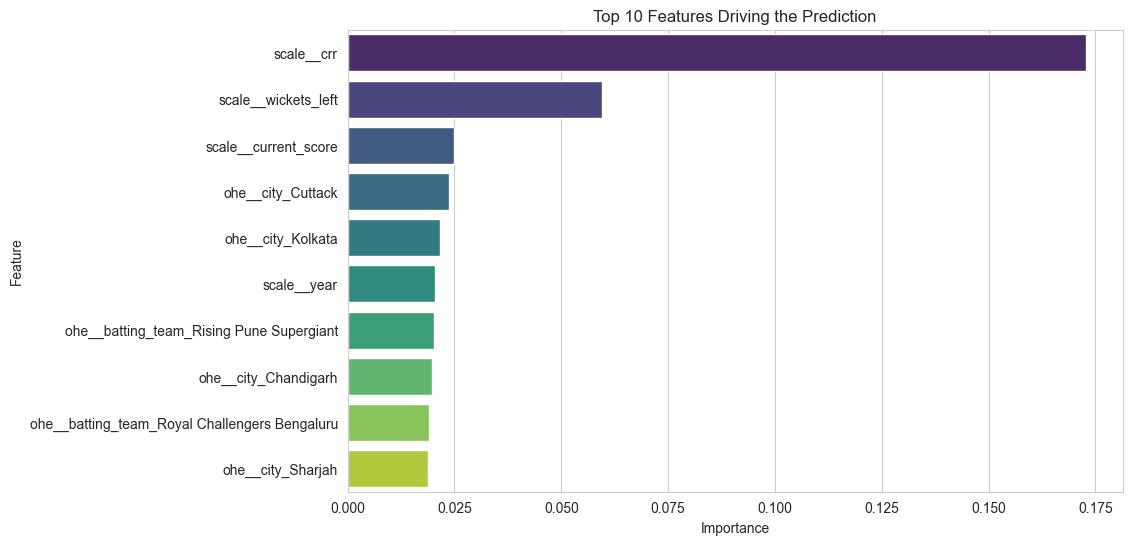

In [19]:
# --- Feature Importance Plot ---
# Extract the model from the pipeline
regressor = final_pipeline.named_steps['regressor']
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = regressor.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Top 10 Features Driving the Prediction')
plt.show()

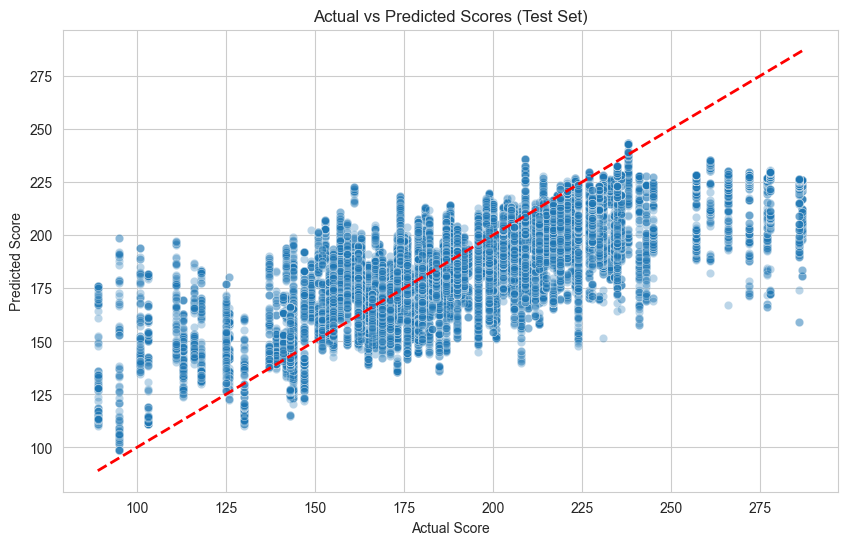

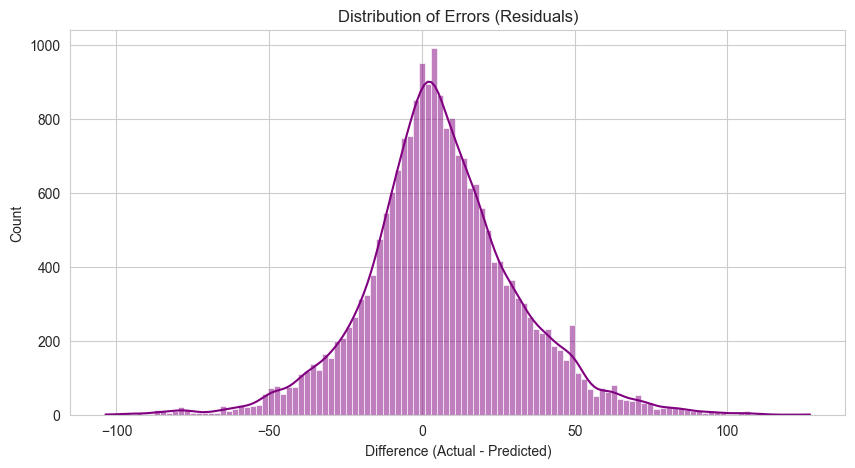

In [20]:
# --- Prediction Error Plot ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, linestyle='--')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Actual vs Predicted Scores (Test Set)')
plt.show()

# --- Residual Plot (Errors) ---
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Distribution of Errors (Residuals)')
plt.xlabel('Difference (Actual - Predicted)')
plt.show()

In [21]:
print("\n" + "="*60)
print("🔎 COMPREHENSIVE LOGIC CHECKS")
print("="*60)

test_batting = 'Mumbai Indians'
test_bowling = 'Chennai Super Kings'
test_city = 'Mumbai'
test_year = 2023

def predict_score(current_score, wickets_left, balls_left=30, runs_last_5=45):
    """Predict final score given match state"""
    crr = (current_score * 6) / (120 - balls_left) if (120 - balls_left) > 0 else 0
    
    input_data = pd.DataFrame({
        'batting_team': [test_batting],
        'bowling_team': [test_bowling],
        'city': [test_city],
        'current_score': [current_score],
        'balls_left': [balls_left],
        'wickets_left': [wickets_left],
        'crr': [crr],
        'runs_last_5': [runs_last_5],
        'year': [test_year]
    })
    return final_pipeline.predict(input_data)[0]

# TEST 1: Wickets Logic (More wickets = Lower score)
print("\n--- TEST 1: Wicket Impact Logic ---")
print("(Keeping Score=100 at 10 overs constant)")
score_2_down = predict_score(current_score=100, wickets_left=8, balls_left=60)
score_5_down = predict_score(current_score=100, wickets_left=5, balls_left=60)
score_8_down = predict_score(current_score=100, wickets_left=2, balls_left=60)

print(f"2 Wickets Down: Predicted Final = {score_2_down:.0f}")
print(f"5 Wickets Down: Predicted Final = {score_5_down:.0f}")
print(f"8 Wickets Down: Predicted Final = {score_8_down:.0f}")

if score_2_down > score_5_down > score_8_down:
    print("✅ CORRECT: More wickets → Lower score")
else:
    print("❌ ERROR: Wicket logic is reversed or broken!")

# TEST 2: Score Logic (Higher current score = Higher final score)
print("\n--- TEST 2: Current Score Impact Logic ---")
print("(Keeping Wickets=2 down, 10 overs done constant)")
low_current = predict_score(current_score=80, wickets_left=8, balls_left=60)
mid_current = predict_score(current_score=100, wickets_left=8, balls_left=60)
high_current = predict_score(current_score=120, wickets_left=8, balls_left=60)

print(f"Current Score 80/2: Predicted Final = {low_current:.0f}")
print(f"Current Score 100/2: Predicted Final = {mid_current:.0f}")
print(f"Current Score 120/2: Predicted Final = {high_current:.0f}")

if low_current < mid_current < high_current:
    print("✅ CORRECT: Higher current score → Higher final score")
else:
    print("❌ ERROR: Score logic is broken!")

# TEST 3: Balls Left Logic (More balls = Higher score potential)
print("\n--- TEST 3: Balls Left Impact Logic ---")
print("(Keeping Current Score=100, Wickets=2 down constant)")
few_balls = predict_score(current_score=100, wickets_left=8, balls_left=12)  # 2 overs
many_balls = predict_score(current_score=100, wickets_left=8, balls_left=60)  # 10 overs

print(f"2 Overs Left: Predicted Final = {few_balls:.0f}")
print(f"10 Overs Left: Predicted Final = {many_balls:.0f}")

if many_balls > few_balls:
    print("✅ CORRECT: More balls left → Higher final score")
else:
    print("❌ ERROR: Balls left logic is broken!")

print("\n" + "="*60)
print("✅ ALL CHECKS COMPLETED!")
print("="*60)


🔎 COMPREHENSIVE LOGIC CHECKS

--- TEST 1: Wicket Impact Logic ---
(Keeping Score=100 at 10 overs constant)
2 Wickets Down: Predicted Final = 199
5 Wickets Down: Predicted Final = 184
8 Wickets Down: Predicted Final = 175
✅ CORRECT: More wickets → Lower score

--- TEST 2: Current Score Impact Logic ---
(Keeping Wickets=2 down, 10 overs done constant)
Current Score 80/2: Predicted Final = 177
Current Score 100/2: Predicted Final = 199
Current Score 120/2: Predicted Final = 218
✅ CORRECT: Higher current score → Higher final score

--- TEST 3: Balls Left Impact Logic ---
(Keeping Current Score=100, Wickets=2 down constant)
2 Overs Left: Predicted Final = 157
10 Overs Left: Predicted Final = 199
✅ CORRECT: More balls left → Higher final score

✅ ALL CHECKS COMPLETED!
